<a href="https://colab.research.google.com/github/thiagotheiry05/Disciplinas-da-Graduacao/blob/main/INTELIG%C3%8ANCIA%20ARTIFICIAL/Unidade%203/Quest%C3%A3o1_Lista3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
import numpy as np
import random
import tensorflow as tf

# Definição da arquitetura da rede neural
def build_dqn_model(input_shape, num_actions):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(24, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(num_actions)
    ])
    return model

# Parâmetros de treinamento
learning_rate = 0.001
gamma = 0.99
epsilon_initial = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 32
target_network_update_frequency = 10

# Definir o ambiente "CartPole"
env = gym.make('CartPole-v1')
num_actions = env.action_space.n
input_shape = env.observation_space.shape

# Construir a rede neural
online_network = build_dqn_model(input_shape, num_actions)
target_network = build_dqn_model(input_shape, num_actions)
target_network.set_weights(online_network.get_weights())

# Compilação do modelo
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_function = tf.keras.losses.MeanSquaredError()

# Variável de memória de replay
replay_memory = []

# Função de atualização dos pesos da rede neural alvo
def update_target_network():
    target_network.set_weights(online_network.get_weights())

# Função de treinamento do agente
def train_agent(num_episodes):
    epsilon = epsilon_initial

    for episode in range(num_episodes):
        state = env.reset()
        state = np.reshape(state, [1, -1])
        done = False
        total_reward = 0

        while not done:
            # Escolha da ação epsilon-greedy
            if np.random.rand() < epsilon:
                action = np.random.randint(num_actions)
            else:
                q_values = online_network.predict(state)
                action = np.argmax(q_values[0])

            # Executar a ação no ambiente
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, -1])

            # Armazenar a transição na memória de replay
            replay_memory.append((state, action, reward, next_state, done))

            if len(replay_memory) > batch_size:
                minibatch = random.sample(replay_memory, batch_size)
                states, actions, rewards, next_states, terminals = zip(*minibatch)
                states = np.concatenate(states)
                next_states = np.concatenate(next_states)

                online_q_values = online_network.predict(states)
                next_q_values = target_network.predict(next_states)

                targets = np.copy(online_q_values)
                for i in range(batch_size):
                    targets[i, actions[i]] = rewards[i] + gamma * np.max(next_q_values[i]) * (1 - terminals[i])

                with tf.GradientTape() as tape:
                    q_values = online_network(states)
                    loss = loss_function(targets, q_values)

                gradients = tape.gradient(loss, online_network.trainable_variables)
                optimizer.apply_gradients(zip(gradients, online_network.trainable_variables))

            # Atualizar o estado atual
            state = next_state

            # Atualizar o episódio
            total_reward += reward

        # Atualizar epsilon
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        # Atualizar a rede neural alvo
        if episode % target_network_update_frequency == 0:
            update_target_network()

        # Imprimir o resultado do episódio
        print(f"Episode: {episode+1}, Total Reward: {total_reward}")

train_agent(num_episodes=10)


1/1 [==============================] - 0s 31ms/step
Episode: 1, Total Reward: 35.0
1/1 [==============================] - 0s 13ms/step
Episode: 2, Total Reward: 33.0
1/1 [==============================] - 0s 15ms/step
Episode: 3, Total Reward: 31.0
1/1 [==============================] - 0s 26ms/step
Episode: 4, Total Reward: 16.0
1/1 [==============================] - 0s 17ms/step
Episode: 5, Total Reward: 18.0
1/1 [==============================] - 0s 15ms/step
Episode: 6, Total Reward: 18.0
1/1 [==============================] - 0s 23ms/step
Episode: 7, Total Reward: 9.0
1/1 [==============================] - 0s 18ms/step
Episode: 8, Total Reward: 10.0
1/1 [==============================] - 0s 13ms/step
Episode: 9, Total Reward: 21.0
1/1 [==============================] - 0s 19ms/step
Episode: 10, Total Reward: 24.0


In [ ]:
!pip install gym
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay


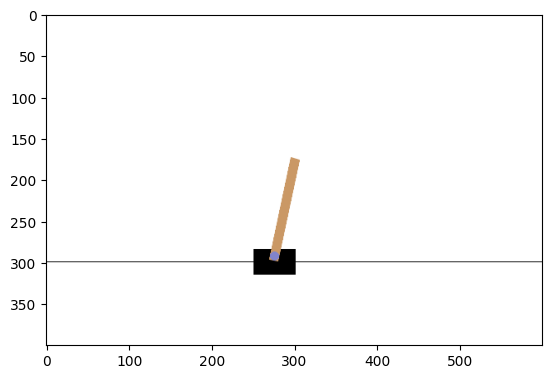

In [1]:
import gym
import matplotlib.pyplot as plt
from IPython import display

# Cria o ambiente CartPole
env = gym.make('CartPole-v1')

observation = env.reset()  # Reinicia o ambiente e retorna a primeira observação

done = False
while not done:
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

    action = env.action_space.sample()  # Escolhe uma ação aleatória
    observation, reward, done, info = env.step(action)  # Executa a ação no ambiente

env.close()  # Fecha o ambiente
